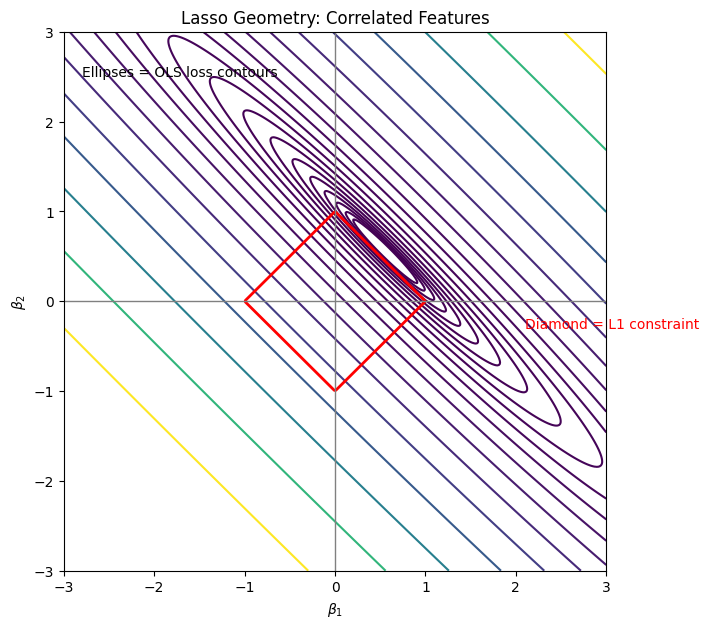

In [ ]:
# example of contour hitting the side of the diamond from LASSO

import numpy as np
import matplotlib.pyplot as plt

# Set up a grid of coefficients β1 and β2
b1 = np.linspace(-3, 3, 400)
b2 = np.linspace(-3, 3, 400)
B1, B2 = np.meshgrid(b1, b2)

# Create an example of correlated features
# The contours are elongated (like correlated variables)
# This is an artificial "loss" surface: (β1 + 0.8β2 - 1)^2 + (0.8β1 + β2 - 1)^2
Z = (B1 + 0.8*B2 - 1)**2 + (0.8*B1 + B2 - 1)**2

# L1 norm constraint (lasso penalty region, a diamond shape)
lambda_val = 1.0
l1_boundary = np.abs(B1) + np.abs(B2)

# Plot
plt.figure(figsize=(7,7))
contours = plt.contour(B1, B2, Z, levels=np.logspace(-2, 1.5, 20), cmap='viridis')
plt.contour(B1, B2, l1_boundary, levels=[lambda_val], colors='red', linewidths=2)

plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_2$')
plt.title('Lasso Geometry: Correlated Features')
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.text(2.1, -0.3, 'Diamond = L1 constraint', color='red')
plt.text(-2.8, 2.5, 'Ellipses = OLS loss contours', color='black')
plt.show()

In [ ]:
# first draft of regions in R^3 outside of unit octahedron that are nearest to faces, edges, vertices

import numpy as np
import plotly.graph_objects as go

# --- Octahedron geometry ---
verts = np.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 1],
    [0, 0, -1]
])

faces = [
    [0, 2, 4], [2, 1, 4], [1, 3, 4], [3, 0, 4],
    [2, 0, 5], [1, 2, 5], [3, 1, 5], [0, 3, 5],
]

edges = [
    (0,2),(2,1),(1,3),(3,0),
    (0,4),(2,4),(1,4),(3,4),
    (0,5),(2,5),(1,5),(3,5)
]
edges = sorted(set(tuple(sorted(e)) for e in edges))

# --- Grid points outside |x|+|y|+|z| <= 1 ---
pad = 0.8
lim = 1.0 + pad
step = 0.08
xs = np.arange(-lim, lim+1e-9, step)
ys = np.arange(-lim, lim+1e-9, step)
zs = np.arange(-lim, lim+1e-9, step)
X, Y, Z = np.meshgrid(xs, ys, zs, indexing='xy')
pts = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
mask = (np.abs(pts).sum(axis=1) > 1.0)
pts_out = pts[mask]

# --- Distance helpers ---
def dist_to_vertices(points, verts):
    return np.linalg.norm(points[:, None, :] - verts[None, :, :], axis=2)

def dist_point_to_segment(points, a, b):
    ap = points - a
    ab = b - a
    ab_len2 = np.dot(ab, ab)
    t = np.clip(np.dot(ap, ab) / ab_len2, 0, 1)
    proj = a + np.outer(t, ab)
    return np.linalg.norm(points - proj, axis=1)

def dist_to_edges(points, verts, edges):
    D = np.empty((len(points), len(edges)))
    for i, (i0, i1) in enumerate(edges):
        D[:, i] = dist_point_to_segment(points, verts[i0], verts[i1])
    return D

def dist_point_to_triangle(points, tri):
    A, B, C = tri
    AB, AC = B - A, C - A
    N = np.cross(AB, AC)
    Nn2 = np.dot(N, N)
    if Nn2 == 0:
        return np.min(np.linalg.norm(points[:, None, :] - tri[None, :, :], axis=2), axis=1)
    dist_plane = np.einsum('ij,j->i', points - A, N) / np.sqrt(Nn2)
    proj = points - np.outer(np.einsum('ij,j->i', points - A, N) / Nn2, N)
    v0, v1 = AB, AC
    v2 = proj - A
    dot00, dot01, dot11 = np.dot(v0, v0), np.dot(v0, v1), np.dot(v1, v1)
    dot02 = np.einsum('ij,j->i', v2, v0)
    dot12 = np.einsum('ij,j->i', v2, v1)
    inv = 1 / (dot00 * dot11 - dot01**2)
    u = (dot11 * dot02 - dot01 * dot12) * inv
    v = (dot00 * dot12 - dot01 * dot02) * inv
    inside = (u >= 0) & (v >= 0) & (u + v <= 1)
    d = np.empty(len(points))
    d[inside] = np.abs(dist_plane[inside])
    outside = ~inside
    if np.any(outside):
        po = points[outside]
        dists = np.vstack([
            dist_point_to_segment(po, A, B),
            dist_point_to_segment(po, B, C),
            dist_point_to_segment(po, C, A)
        ])
        d[outside] = dists.min(axis=0)
    return d

def dist_to_faces(points, verts, faces):
    D = np.empty((len(points), len(faces)))
    for i, f in enumerate(faces):
        D[:, i] = dist_point_to_triangle(points, verts[np.array(f)])
    return D

# --- Compute distances and color assignments ---
Dv = dist_to_vertices(pts_out, verts)
De = dist_to_edges(pts_out, verts, edges)
Df = dist_to_faces(pts_out, verts, faces)
mins = np.vstack([Dv.min(1), De.min(1), Df.min(1)]).T
type_id = mins.argmin(1)
types = np.array(['vertex', 'edge', 'face'])
colors = dict(vertex='red', edge='green', face='blue')

# --- Plot with Plotly ---
fig = go.Figure()
xv, yv, zv = verts.T
i_idx, j_idx, k_idx = zip(*faces)
fig.add_trace(go.Mesh3d(x=xv, y=yv, z=zv, i=i_idx, j=j_idx, k=k_idx,
                        opacity=0.25, color='lightgray', name='octahedron'))

for label in types:
    pts_t = pts_out[type_id == np.where(types == label)[0][0]]
    fig.add_trace(go.Scatter3d(
        x=pts_t[:,0], y=pts_t[:,1], z=pts_t[:,2],
        mode='markers', marker=dict(size=3, opacity=0.6, color=colors[label]),
        name=f'closest to {label}'
    ))

fig.update_layout(scene=dict(aspectmode='cube'), title='Outside regions by nearest feature')
fig.show()


In [ ]:
# second draft of regions in R^3 outside of unit octahedron that are nearest to faces, edges, vertices
# hard to interpret, needs more iterations


import numpy as np
import plotly.graph_objects as go

# --- Octahedron geometry ---
verts = np.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 1],
    [0, 0, -1]
])

faces = [
    [0, 2, 4], [2, 1, 4], [1, 3, 4], [3, 0, 4],
    [2, 0, 5], [1, 2, 5], [3, 1, 5], [0, 3, 5],
]

edges = sorted(set(tuple(sorted(e)) for e in [
    (0,2),(2,1),(1,3),(3,0),
    (0,4),(2,4),(1,4),(3,4),
    (0,5),(2,5),(1,5),(3,5)
]))

# --- Grid points outside |x|+|y|+|z| <= 1 ---
pad, lim, step = 0.8, 1.8, 0.08
xs = np.arange(-lim, lim+1e-9, step)
ys = np.arange(-lim, lim+1e-9, step)
zs = np.arange(-lim, lim+1e-9, step)
X, Y, Z = np.meshgrid(xs, ys, zs, indexing='xy')
pts = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
mask = (np.abs(pts).sum(axis=1) > 1.0)
pts_out = pts[mask]

# --- Distance helpers ---
def dist_to_vertices(points, verts):
    return np.linalg.norm(points[:, None, :] - verts[None, :, :], axis=2)

def dist_point_to_segment(points, a, b):
    ap = points - a
    ab = b - a
    ab_len2 = np.dot(ab, ab)
    t = np.clip(np.dot(ap, ab) / ab_len2, 0, 1)
    proj = a + np.outer(t, ab)
    return np.linalg.norm(points - proj, axis=1)

def dist_to_edges(points, verts, edges):
    D = np.empty((len(points), len(edges)))
    for i, (i0, i1) in enumerate(edges):
        D[:, i] = dist_point_to_segment(points, verts[i0], verts[i1])
    return D

def dist_point_to_triangle(points, tri):
    A, B, C = tri
    AB, AC = B - A, C - A
    N = np.cross(AB, AC)
    Nn2 = np.dot(N, N)
    if Nn2 == 0:
        return np.min(np.linalg.norm(points[:, None, :] - tri[None, :, :], axis=2), axis=1)
    dist_plane = np.einsum('ij,j->i', points - A, N) / np.sqrt(Nn2)
    proj = points - np.outer(np.einsum('ij,j->i', points - A, N) / Nn2, N)
    v0, v1 = AB, AC
    v2 = proj - A
    dot00, dot01, dot11 = np.dot(v0, v0), np.dot(v0, v1), np.dot(v1, v1)
    dot02 = np.einsum('ij,j->i', v2, v0)
    dot12 = np.einsum('ij,j->i', v2, v1)
    inv = 1 / (dot00 * dot11 - dot01**2)
    u = (dot11 * dot02 - dot01 * dot12) * inv
    v = (dot00 * dot12 - dot01 * dot02) * inv
    inside = (u >= 0) & (v >= 0) & (u + v <= 1)
    d = np.empty(len(points))
    d[inside] = np.abs(dist_plane[inside])
    outside = ~inside
    if np.any(outside):
        po = points[outside]
        dists = np.vstack([
            dist_point_to_segment(po, A, B),
            dist_point_to_segment(po, B, C),
            dist_point_to_segment(po, C, A)
        ])
        d[outside] = dists.min(axis=0)
    return d

def dist_to_faces(points, verts, faces):
    D = np.empty((len(points), len(faces)))
    for i, f in enumerate(faces):
        D[:, i] = dist_point_to_triangle(points, verts[np.array(f)])
    return D

# --- Compute distances and assign colors ---
Dv = dist_to_vertices(pts_out, verts)
De = dist_to_edges(pts_out, verts, edges)
Df = dist_to_faces(pts_out, verts, faces)
mins = np.vstack([Dv.min(1), De.min(1), Df.min(1)]).T
type_id = mins.argmin(1)
types = np.array(['vertex', 'edge', 'face'])
colors = dict(vertex='rgba(255,0,0,0.35)', edge='rgba(0,255,0,0.35)', face='rgba(0,0,255,0.35)')

# --- Build the plot ---
fig = go.Figure()

# semi-transparent gray octahedron
xv, yv, zv = verts.T
i_idx, j_idx, k_idx = zip(*faces)
fig.add_trace(go.Mesh3d(
    x=xv, y=yv, z=zv, i=i_idx, j=j_idx, k=k_idx,
    opacity=0.25, color='lightgray', name='octahedron'
))

# translucent outside regions
for label in types:
    pts_t = pts_out[type_id == np.where(types == label)[0][0]]
    fig.add_trace(go.Scatter3d(
        x=pts_t[:,0], y=pts_t[:,1], z=pts_t[:,2],
        mode='markers',
        marker=dict(size=3, opacity=0.35, color=colors[label]),
        name=f'closest to {label}'
    ))

fig.update_layout(
    width=900, height=800,
    scene=dict(aspectmode='cube',
               xaxis=dict(title='x'), yaxis=dict(title='y'), zaxis=dict(title='z')),
    title='Translucent regions outside octahedron colored by nearest feature type'
)
fig.show()
